In [213]:
import os
import pandas as pd
import numpy as np
from numpy import where
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, auc, roc_auc_score, roc_curve, classification_report, cohen_kappa_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [214]:
df = pd.read_csv('df_fe_combined.csv')

## Baseline: Decision Tree

In [119]:
from sklearn.tree import DecisionTreeClassifier

In [122]:
X_rain = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Define the rolling forward cross-validation
tscv = TimeSeriesSplit(n_splits=8)

# Define the Random Forest model and set the hyperparameters
DT_model = DecisionTreeClassifier(max_depth=5)

# Define a variable to store the sum of accuracy scores for all folds
acc_sum = 0

# Define a list to store the dates for each fold
fold_dates = []

# Train and evaluate the model for each fold in the cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    # extract the training and validation sets
    X_train_cv, X_val = X_train.loc[train_index], X_train.loc[test_index]
    y_train_cv, y_val = y_train.loc[train_index], y_train.loc[test_index]

    # store the date for the current validation
    #fold_date = df_enc.loc[test_index[-1], 'MONTH']
    #print(fold_date)
    #fold_dates.append(fold_date)

    # train the model on the training set
    y_train_cv_r = y_train_cv.values.ravel()
    DT_model.fit(X_train_cv, y_train_cv)

    # make predictions on the validation set
    y_pred = DT_model.predict(X_val)

    # evaluate the performance using accuracy score
    DT_acc = accuracy_score(y_val, y_pred)
    print(f"Accuracy: {DT_acc:.3f}")
    acc_sum += RF_acc

# compute the average accuracy score across all folds
DT_avg_acc = acc_sum / tscv.get_n_splits()

print(f"Average accuracy across all folds: {DT_avg_acc:.3f}")

# Fit the model on the entire training set
y_train_r = y_train.values.ravel()
DT_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = DT_model.predict(X_test)

# Evaluate the performance on the test set
DT_acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {DT_acc:.3f}")

Accuracy: 0.765
Accuracy: 0.789
Accuracy: 0.771
Accuracy: 0.814
Accuracy: 0.781
Accuracy: 0.882
Accuracy: 0.680
Accuracy: 0.647
Average accuracy across all folds: 0.640
Test accuracy: 0.656


In [ ]:
Decision_Tree_results = {
    "Parameters": DT_model.get_params,
    "Average accuracy across all folds": DT_avg_acc,
    "Test accuracy": DT_acc
}
print(Decision_Tree_results)

## Model Evaluation & Performance

## Error Analysis

In [ ]:
# Confusion Matrix
target_names = ['Highest Fire-Risk', 'High Fire-Risk',
                'Moderate Fire-Risk', 'Low Fire-Risk', 'Lowest Fire-Risk']
DT_confusion_matrix = confusion_matrix(y_test, y_pred)
DT_confusion_matrix_n = DT_confusion_matrix.astype('float') / DT_confusion_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(DT_confusion_matrix_n, annot=True, fmt='.2f', xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

DT_cm_df = pd.DataFrame(DT_confusion_matrix_n, index=['True 1', 'True 2', 'True 3', 'True 4', 'True 5'],
                             columns=target_names)

# Display the DataFrame
DT_cm_df

# File Output
DT_cm_file_name = 'DT_confusion_matrix.xlsx'
DT_cm_file_path = 'Data/Data_visualization_tables/' + DT_cm_file_name
if os.path.exists(DT_cm_file_name):
    os.remove(DT_cm_file_name)
    DT_cm_df.to_csv(DT_cm_file_path, index=True)
else:
    DT_cm_df.to_csv(DT_cm_file_path, index=True)

In [ ]:
# Classification report
target_names = ['Highest Fire-Risk', 'High Fire-Risk',
                'Moderate Fire-Risk', 'Low Fire-Risk', 'Lowest Fire-Risk']
DT_report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

# Convert the dictionary to a DataFrame
DT_report_df = pd.DataFrame(DT_report_dict).transpose()

# Display the DataFrame
DT_report_df

# File Output
DT_r_file_name = 'DT_class_report_matrix.xlsx'
DT_r_file_path = 'Data/Data_visualization_tables/' + DT_r_file_name
if os.path.exists(DT_r_file_name):
    os.remove(DT_r_file_name)
    DT_report_df.to_csv(DT_r_file_path, index=True)
else:
    DT_report_df.to_csv(DT_r_file_path, index=True)

In [126]:
# ROC AUC
dt_probs = DT_model.predict_proba(X_test)

#Macro averaging: Taking fpr, tpr of each classification (one vs rest) and taking the average
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

macro_roc_auc_ovr = roc_auc_score(
    y_test,
    dt_probs,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

Macro-averaged One-vs-Rest ROC AUC score:
0.93


In [128]:
# generating dataframe for plotting roc curve
y_test_arr = y_test.to_numpy()
n_classes = len(y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique())
classes = y_test['FIRE_RISK_1_MONTH_FORWARD_SHIFT'].unique()

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_arr, dt_probs[:,i],pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(n_classes):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

RF_d = {'FPR':fpr_grid,'TPR':mean_tpr}
RF_roc_auc = pd.DataFrame(data=RF_d)

RF_roc_auc_file_name = 'RF_roc_auc.xlsx'
RF_cm_file_path = 'Data/Data_visualization_tables/' + RF_roc_auc_file_name
if os.path.exists(RF_roc_auc_file_name):
    os.remove(RF_roc_auc_file_name)
    RF_roc_auc.to_csv(RF_cm_file_path, index=True)
else:
    RF_roc_auc.to_csv(RF_cm_file_path,index=True)

Macro-averaged One-vs-Rest ROC AUC score:
0.93


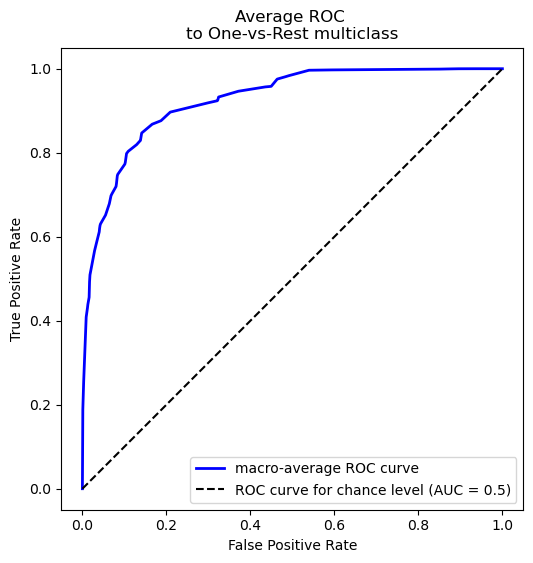

In [129]:
# Plotting roc curve

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve",
    color="blue",
    linewidth=2,
)

plt.plot([0, 1], [0, 1], "k--", label="ROC curve for chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC \nto One-vs-Rest multiclass")
plt.legend()
plt.show()

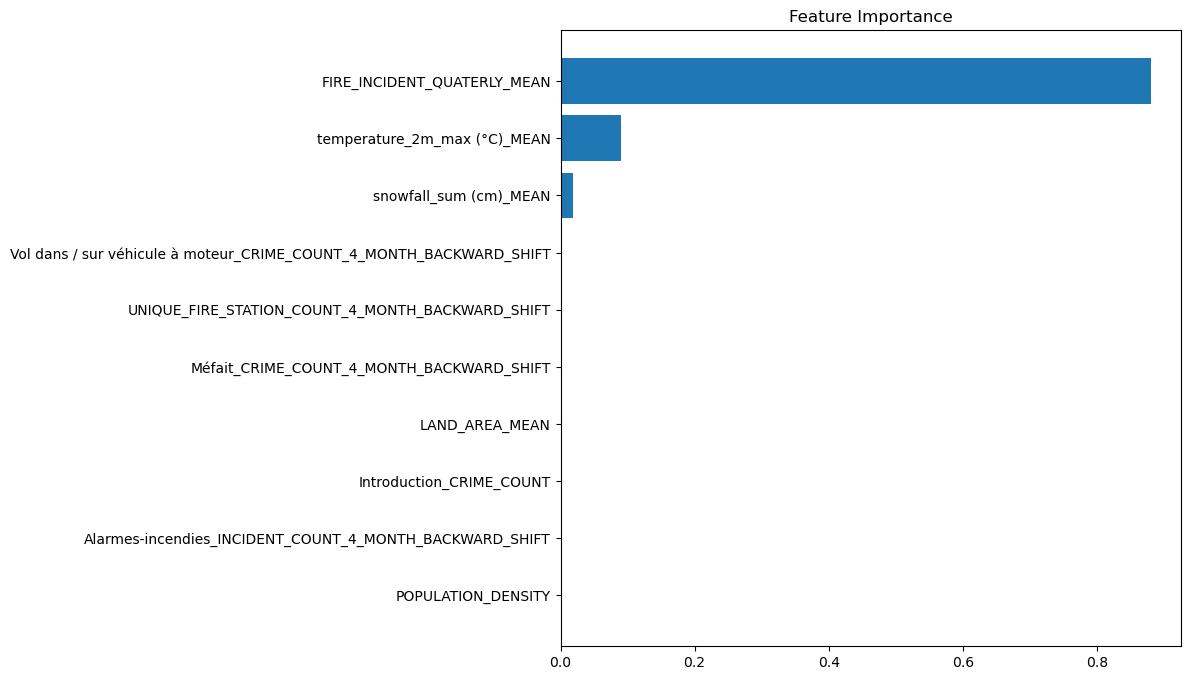

In [130]:
#feature importance
fi = DT_model.feature_importances_
sorted_idx = np.argsort(fi)
fig = plt.figure(figsize=(8, 8))
plt.barh(range(10), fi[sorted_idx[-10:]], align='center')
plt.yticks(range(10), [np.array(X_train.columns)[i] for i in sorted_idx[-10:]])
plt.title('Feature Importance')
plt.show()